# Example Project

We're going to import Twitter data into Neo4j and then do various analysis on top of this dataset including plotting, graph algorithms, and graph visualizations.

* Import
* Plotting / Charting
* Graph Algorithms
* Graph Visualization

# Import

The script for importing data from Twitter's API is in [`scripts/twitter.py`](https://github.com/nicolewhite/neo4j-jupyter/blob/master/scripts/twitter.py). This was used to upload tweets that contained either the words "ddtx16" or "datadaytexas" to Neo4j.

## Packages

In [2]:
import os
import sys
import time
import requests
from py2neo import Graph, Node, Relationship

## Uniqueness Constraints

Neo4j supports uniqueness constraints on given label, property pairs.

In [ ]:
graph = Graph()

graph.run("CREATE CONSTRAINT ON (u:User) ASSERT u.username IS UNIQUE")
graph.run("CREATE CONSTRAINT ON (t:Tweet) ASSERT t.id IS UNIQUE")
graph.run("CREATE CONSTRAINT ON (h:Hashtag) ASSERT h.name IS UNIQUE")

## Twitter API

In [ ]:
TWITTER_BEARER = os.environ["TWITTER_BEARER"]

headers = dict(accept="application/json", Authorization="Bearer " + TWITTER_BEARER)

payload = dict(
    count=100,
    result_type="recent",
    lang="en",
    q=sys.argv[1]
)

base_url = "https://api.twitter.com/1.1/search/tweets.json?"

## Find Tweets

In [9]:
def find_tweets(since_id):
    payload["since_id"] = since_id
    url = base_url + "q={q}&count={count}&result_type={result_type}&lang={lang}&since_id={since_id}".format(**payload)

    r = requests.get(url, headers=headers)
    tweets = r.json()["statuses"]

    return tweets

## Upload Tweets to Neo4j

In [11]:
def upload_tweets(tweets):
    for t in tweets:
        u = t["user"]
        e = t["entities"]

        tweet = Node("Tweet", id=t["id"])
        graph.merge(tweet)
        tweet["text"] = t["text"]
        tweet.push()

        user = Node("User", username=u["screen_name"])
        graph.merge(user)

        graph.merge(Relationship(user, "POSTS", tweet))

        for h in e.get("hashtags", []):
            hashtag = Node("Hashtag", name=h["text"].lower())
            graph.merge(hashtag)
            graph.merge(Relationship(hashtag, "TAGS", tweet))

        for m in e.get('user_mentions', []):
            mention = Node("User", username=m["screen_name"])
            graph.merge(mention)
            graph.merge(Relationship(tweet, "MENTIONS", mention))

        reply = t.get("in_reply_to_status_id")

        if reply:
            reply_tweet = Node("Tweet", id=reply)
            graph.merge(reply_tweet)
            graph.merge(Relationship(tweet, "REPLY_TO", reply_tweet))

        ret = t.get("retweeted_status", {}).get("id")

        if ret:
            retweet = Node("Tweet", id=ret)
            graph.merge(retweet)
            graph.merge(Relationship(tweet, "RETWEETS", retweet))

## Run It!

In [ ]:
since_id = -1

while True:
    try:
        tweets = find_tweets(since_id=since_id)

        if not tweets:
            print("No tweets found.")
            time.sleep(60)
            continue

        since_id = tweets[0].get("id")
        upload_tweets(tweets)

        print("{} tweets uploaded!".format(len(tweets)))
        time.sleep(60)

    except Exception as e:
        print(e)
        time.sleep(60)
        continue

## Visualize the Model

In [4]:
from scripts.vis import draw
options = {"User": "username", "Hashtag": "name"}

draw(graph, options, physics=True, limit=30)

# Plotting

Let's gather some basic insights by creating `plotly` charts.

## Packages

In [5]:
%load_ext cypher
import plotly.plotly as py
from plotly.graph_objs import *

## What are the top hashtags?

Find hashtags ordered by the number of tweets they've tagged.

In [24]:
result = %cypher MATCH (hashtag:Hashtag)-[:TAGS]->(tweet:Tweet)         \
                 WHERE hashtag.name <> 'rstats'                         \
                 RETURN hashtag.name AS hashtag, count(tweet) AS tweets \
                 ORDER BY tweets DESC LIMIT 5
        
df = result.get_dataframe()
df.head()

5 rows affected.


,hashtag,tweets
0,datascience,18
1,r,5
2,abdsc,3
3,python,3
4,predictiveanalytics,2


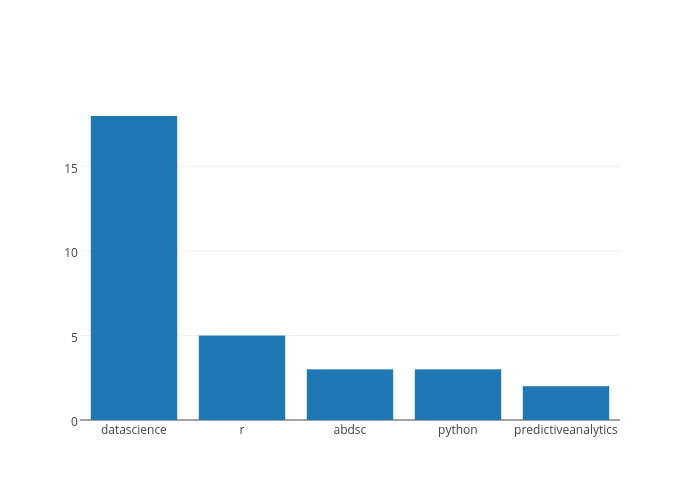

In [25]:
data = Data([Bar(x=df["hashtag"], y=df["tweets"])])

py.image.ishow({'data': data})

## What's the hashtag and mention count distribution?

In [26]:
result = %cypher MATCH (tweet:Tweet)                                   \
                 RETURN tweet.id,                                      \
                        size((:Hashtag)-[:TAGS]->(tweet)) AS hashtags, \
                        size((tweet)-[:MENTIONS]->(:User)) AS mentions
            
df = result.get_dataframe()
del df["tweet.id"]
df.head()

63 rows affected.


,hashtags,mentions
0,0,0
1,1,2
2,0,0
3,1,0
4,2,1


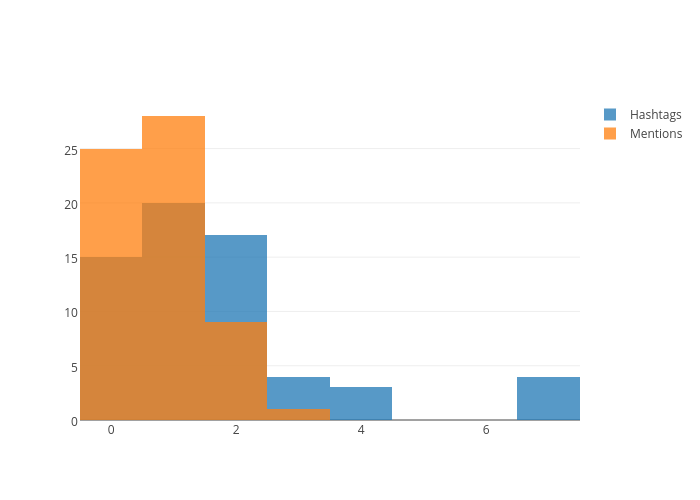

In [27]:
hashtags = Histogram(x=df["hashtags"], opacity=0.75, name="Hashtags")
mentions = Histogram(x=df["mentions"], opacity=0.75, name="Mentions")
data = Data([hashtags, mentions])
layout = Layout(barmode="overlay")
fig = Figure(data=data, layout=layout)

py.image.ishow(fig)

## Heatmap of hashtag co-occurrence

In [28]:
result = %cypher MATCH (h:Hashtag)                           \
                 WHERE h.name <> "rstats"                    \
                 WITH h, size((h)-[:TAGS]->(:Tweet)) AS tags \
                 ORDER BY tags DESC                          \
                 LIMIT 15                                    \
                                                             \
                 WITH collect(h) AS top_hash                 \
                 UNWIND top_hash AS h1                       \
                 UNWIND top_hash AS h2                       \
                                                             \
                 MATCH (h1)-[:TAGS]->(:Tweet)<-[:TAGS]-(h2)  \
                 WHERE h1.name < h2.name                     \
                 RETURN h1.name, h2.name, count(*) AS weight
            
df = result.get_dataframe()
df.head()

27 rows affected.


,h1.name,h2.name,weight
0,distributedsystems,java,3
1,abdsc,datascience,3
2,java,python,3
3,datascience,r,2
4,java,spark,3


In [29]:
names = list(set(list(df["h1.name"]) + list(df["h2.name"])))
heat = [[0 for i in range(len(names))] for j in range(len(names))] 

for idx, row in df.iterrows():
    i = names.index(row["h1.name"])
    j = names.index(row["h2.name"])
    heat[i][j] = row["weight"]

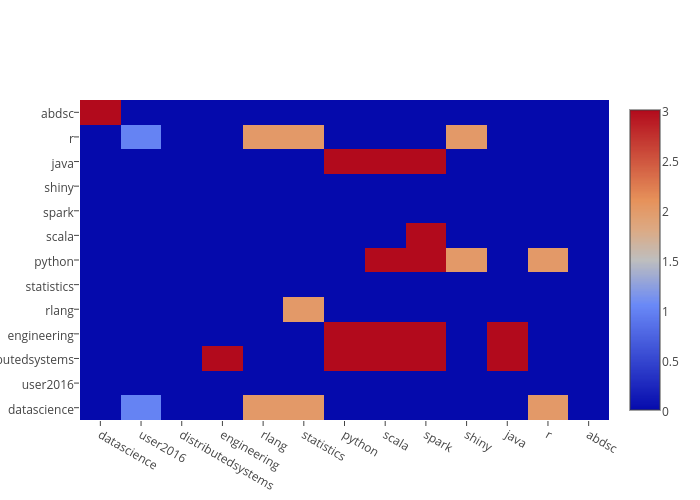

In [30]:
import plotly.graph_objs as go

data = [go.Heatmap(z = heat, x = names, y = names)]
py.image.ishow({'data': data})

# Graph Algorithms

The typical workflow consists of retrieving a subgraph from Neo4j via Cypher and analyzing this graph in `igraph`.

## A subgraph of users retweeting other users

In [31]:
from igraph import Graph as IGraph

query = """
MATCH (user1:User)-[:POSTS]->(retweet:Tweet)-[:RETWEETS]->(tweet:Tweet),
      (user2:User)-[:POSTS]->(tweet)
RETURN user1.username, user2.username, count(*) AS weight
"""

data = graph.run(query)

ig = IGraph.TupleList(data, weights=True)
ig

### Which users have the highest betweenness?

$betweenness(v) = \sum_{s, t \in V} \frac{\sigma_{st}(v)}{\sigma_{st}}$

The betweenness centrality of a node $v$ is the number of shortest paths that pass through $v$, $\sigma_{st}(v)$,  divided by the total number of shortest paths, $\sigma_{st}$.

In [32]:
between = [(node["name"], node.betweenness()) for node in ig.vs]
top = sorted(between, key=lambda x: x[1], reverse=True)
top[:5]

[('revodavid', 10.0),
 ('Rbloggers', 6.0),
 ('raymondpeck3', 1.0),
 ('kuanhoong', 0.0),
 ('ozjimbob', 0.0)]

### Which users have the highest closeness?

$closeness(v) = \frac{1}{\sum_{x} d(v, x)}$

The closeness centrality is the reciprocal of a node's farness, or sum of its shortest path distances from all other nodes in the graph.

In [33]:
close = [(node["name"], node.closeness()) for node in ig.vs]
top = sorted(close, key=lambda x: x[1], reverse=True)
top[:5]

[('revodavid', 0.09090909090909091),
 ('kuanhoong', 0.08875739644970414),
 ('josefslerka', 0.08875739644970414),
 ('permutans', 0.08875739644970414),
 ('HoloMarkeD', 0.08875739644970414)]

### Community detection

In [39]:
clusters = IGraph.community_walktrap(ig, weights="weight")
clusters = clusters.as_clustering()
len(clusters)

4

In [40]:
nodes = [{"id": node.index, "label": node["name"]} for node in ig.vs]

for node in nodes:
    node["group"] = clusters.membership[node["id"]]
    
nodes[:5]

[{'group': 0, 'id': 0, 'label': 'kuanhoong'},
 {'group': 0, 'id': 1, 'label': 'revodavid'},
 {'group': 1, 'id': 2, 'label': 'ozjimbob'},
 {'group': 1, 'id': 3, 'label': 'Rbloggers'},
 {'group': 0, 'id': 4, 'label': 'josefslerka'}]

In [41]:
edges = [{"from": x[0], "to": x[1]} for x in ig.get_edgelist()]
edges[:5]

[{'from': 0, 'to': 1},
 {'from': 2, 'to': 3},
 {'from': 1, 'to': 4},
 {'from': 5, 'to': 6},
 {'from': 6, 'to': 7}]

In [42]:
from scripts.vis import vis_network
vis_network(nodes, edges, physics=True)

# Graph Visualization

## jgraph

Let's visualize (in 3D!) the structure of users retweeting and replying to other users.

In [44]:
import jgraph

query = """
MATCH (user1:User)-[:POSTS]->(:Tweet)-[:RETWEETS|REPLY_TO]->(:Tweet)<-[:POSTS]-(user2:User)
RETURN ID(user1), ID(user2)
"""

data = graph.run(query)
tup = [tuple(x) for x in data]

jgraph.draw(tup)